In [16]:
import numpy as np
import keras
from dataset_generator import TimeWindowDatasetGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder

In [17]:
data_generator = TimeWindowDatasetGenerator()
labeled_data = data_generator.get_labelled_timewindow_dataframe(student_data_filepath='task/student_data.csv',
                                                                time_window=10,
                                                                label_feature='affect',
                                                                exclude_after_notification=False,
                                                                exclude_after_engagement=False)


labeled_data

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context,label_id,label
12763,1,493272,884.0,1564.0,3767.0,2103379.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,RELAXED
12764,1,493311,900.0,1518.0,3782.0,2104145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,RELAXED
12765,1,493351,894.0,1553.0,3734.0,2104953.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,RELAXED
12766,1,493391,907.0,1488.0,3729.0,2105398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,RELAXED
12767,1,493431,861.0,1559.0,3731.0,2105114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,RELAXED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101814,58,6184903,453.0,552.0,4126.0,2126027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240,HAPPY
8101815,58,6184943,494.0,607.0,4059.0,2126361.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240,HAPPY
8101816,58,6184983,695.0,841.0,4124.0,2127234.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240,HAPPY
8101817,58,6185023,497.0,591.0,4329.0,2128049.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240,HAPPY


In [18]:
def preprocess_data(data):
  
    data = data.drop(columns=['ppgValue', 'notification', 'engagement','context','affect','hr','hrIbi','hrStatus','ibiStatus',])

    scaler = StandardScaler()
    numerical_cols = ['x', 'y', 'z']
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols].ffill())

    label_encoder = LabelEncoder()
    data['label'] = label_encoder.fit_transform(data['label'])

    return data

In [19]:
processed_data = preprocess_data(labeled_data)
processed_data

,sessionId,timestamp,x,y,z,label_id,label
12763,1,493272,0.769742,0.827824,0.279626,1,2
12764,1,493311,0.783048,0.800829,0.290323,1,2
12765,1,493351,0.778058,0.821369,0.256091,1,2
12766,1,493391,0.788869,0.783223,0.252526,1,2
12767,1,493431,0.750615,0.824890,0.253952,1,2
...,...,...,...,...,...,...,...
8101814,58,6184903,0.411319,0.233920,0.535653,240,1
8101815,58,6184943,0.445415,0.266198,0.487871,240,1
8101816,58,6184983,0.612568,0.403523,0.534227,240,1
8101817,58,6185023,0.447910,0.256808,0.680426,240,1


In [20]:
grouped = processed_data.groupby('label_id')

min = len(grouped.get_group(1))
for i in range(len(grouped)-1):
    if len(grouped.get_group(i+2))<min:
        min = len(grouped.get_group(i+2))

X = []
Y = []
for i in range(len(grouped)):
    X.append(grouped.get_group(i+1)[["x", "y", "z"]][:min])
    Y.append(grouped.get_group(i+1).iloc[0][["label"]])

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(240, 259, 3)
(240, 1)


In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(216, 259, 3)
(216, 1)
(24, 259, 3)
(24, 1)


In [22]:
model = Sequential()
model.add(LSTM(64,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(4, activation='softmax'))

model.summary()

/home/shenoy/bbdc/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 259, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,780 (327.27 KB)

 Trainable params: 83,780 (327.27 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
adam_optimizer = keras.optimizers.AdamW(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [27]:
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.5180 - loss: 1.4335 - val_accuracy: 0.4545 - val_loss: 1.4502
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.4799 - loss: 1.4006 - val_accuracy: 0.4545 - val_loss: 1.3799
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4642 - loss: 1.3692 - val_accuracy: 0.4545 - val_loss: 1.3146
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.4834 - loss: 1.2409 - val_accuracy: 0.4545 - val_loss: 1.2576
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4222 - loss: 1.2747 - val_accuracy: 0.4545 - val_loss: 1.2133
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.4498 - loss: 1.2006 - val_accuracy: 0.4545 - val_loss: 1.1763
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4833 - loss: 1.1315 - val_accuracy: 0.4545 - val_loss: 1.1403
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4875 - loss: 1.0805 - val_accuracy: 0.4545 - v

In [28]:
Y_pred = model.predict(X_test)

Y_pred = np.argmax(Y_pred, axis=1)

from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

# You can also print a classification report for more detailed evaluation metrics
print(classification_report(Y_test, Y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Accuracy: 0.625
              precision    recall  f1-score   support

         1.0       0.62      1.00      0.77        15
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         1

    accuracy                           0.62        24
   macro avg       0.21      0.33      0.26        24
weighted avg       0.39      0.62      0.48        24



/home/shenoy/bbdc/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shenoy/bbdc/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shenoy/bbdc/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Multi Input Model Definition

In [12]:
# define two sets of inputs
inputA = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
inputB = keras.Input(shape=(4,))
# the first branch operates on the first input
x = LSTM(64,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)(inputA)
x = LSTM(64)(x)
x = Dense(8, activation="relu")(x)
x = Dense(4, activation="relu")(x)
x = keras.Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(32, activation="relu")(inputB)
y = Dense(4, activation="relu")(y)
y = keras.Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = keras.layers.concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = keras.Model(inputs=[x.input, y.input], outputs=z)
model.summary()

/home/shenoy/bbdc/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 259, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 259, 64)   │     17,408 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     33,024 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 8)         │        520 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │        160 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 4)         │         36 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 4)         │        132 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8)         │          0 │ dense_17[0][0],   │
│ (Concatenate)       │                   │            │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 2)         │         18 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │          3 │ dense_20[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,301 (200.39 KB)

 Trainable params: 51,301 (200.39 KB)

 Non-trainable params: 0 (0.00 B)

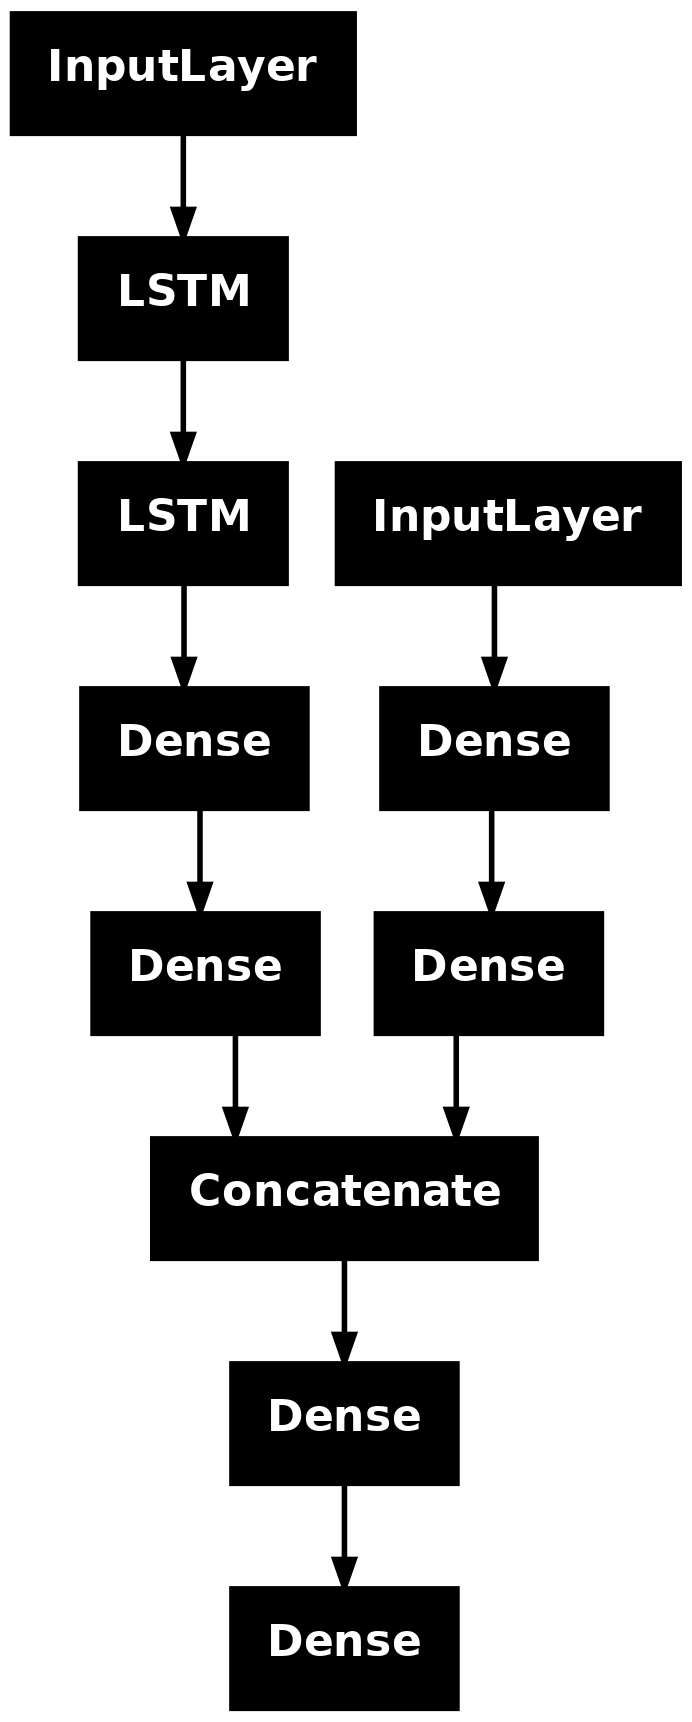

In [13]:
keras.utils.plot_model(model)